In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json
from datetime import datetime
import scipy.stats


import scipy.stats as spstats
# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['logs', 'feature_development.ipynb', 'data', 'data_and_processing_description.ipynb', 'featured_eeg_prediction.ipynb', 'featured_prediction_random_forest.ipynb', 'window_timings_and_IBI.ipynb', 'gait_data_exploration.ipynb', 'featured_eeg_prediction_gradient_boosting.ipynb', 'Analyse_results.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'featured_E4_prediction.ipynb', 'data_investigation_scratch.ipynb', 'grouping_and_crossvalidation.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")


thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from predicament.utils.config import DREEM_EEG_CHANNELS
from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import WINDOWED_BASE_PATH
from predicament.utils.config import E4_FULL_DIRPATHS
from predicament.utils.config import E4_IBI_FILE

from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.windowed import get_window_start_in_event_time
from predicament.data.windowed import get_window_duration
from predicament.data.windowed import correct_window_indices
from predicament.data.windowed import insert_window_start_and_end_times
from predicament.data.windowed import get_window_start_times_for_participant


from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from prepare_evaluation_data import load_dataframe_and_config


In [5]:
from predicament.data.events import load_event_info_from_csv


In [6]:
from predicament.utils.config import E4_CSV_FILES
from predicament.utils.config import E4_FULL_DIRPATHS
E4_FULL_DIRPATHS

{'VG_01': '../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/',
 'VG_03': '../data/CARE_HOME_DATA/./VG03/E4_9921_12_16/',
 'VG_05': '../data/CARE_HOME_DATA/./VG05/E4_9921_13_24/',
 'VG_06': '../data/CARE_HOME_DATA/./VG06/E4_51021_13_33/',
 'VG_07': '../data/CARE_HOME_DATA/./VG07/E4_51021_15_39/',
 'VG_08': '../data/CARE_HOME_DATA/./VG08/E4_71021_10_42/',
 'VG_09': '../data/CARE_HOME_DATA/./VG09/E4_11221_14_46/',
 'VG_10': '../data/CARE_HOME_DATA/./VG10/E4_31221_11_17/',
 'VH_01': '../data/CARE_HOME_DATA/./VH01/E4_61021_11_03/',
 'VH_02': '../data/CARE_HOME_DATA/./VH02/E4_61021_13_59/',
 'VH_03': '../data/CARE_HOME_DATA/./VH03/E4_11221_11_22/'}

In [7]:
subdir = '20231206193533'
featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featureddf, featured_config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [8]:
# we collect all the general information about the datafile
# fro mthe config file
# in particular we need to know window lengths, window steps (strides)
# and sample rates as well as the mapping from label (condition_id) to 
# condition name
n_channels = int(featured_config['LOAD']['n_channels'])
channels = json.loads(featured_config['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(featured_config['LOAD']['participant_list'].replace("'",'"'))
label_mapping = json.loads(featured_config['LOAD']['label_mapping'].replace("'",'"'))
sample_rate = int(featured_config['LOAD']['sample_rate'])
window_size = int(featured_config['LOAD']['window_size'])
window_step = int(featured_config['LOAD']['window_step'])
time = window_size/sample_rate
print(f"sample_rate: {sample_rate}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")
window_duration = get_window_duration(window_size, sample_rate)

print(f"window_size: {window_size}, window_step: {window_step}, window_duration: {window_duration}")

sample_rate: 64, n_samples = 256, time: 4.0s, n_channels: 7
window_size: 256, window_step: 32, window_duration: 4.0


In [9]:
participant_list

['VG_01',
 'VG_03',
 'VG_05',
 'VG_06',
 'VG_07',
 'VG_08',
 'VG_09',
 'VG_10',
 'VH_01',
 'VH_02',
 'VH_03']

In [10]:
# we must load the participant event objects for the observational
# data
all_participants_events = load_event_info_from_csv(
        participant_list)

VG_01:setup is valid but timestamps have issues. What does valid mean?
VG_01:baseline is valid but timestamps have issues. What does valid mean?
VG_06:takeoff_EEG is valid but timestamps have issues. What does valid mean?
VG_07:takeoff_EEG is valid but timestamps have issues. What does valid mean?
VG_08:family_inter is valid but timestamps have issues. What does valid mean?
VG_10:setup is valid but timestamps have issues. What does valid mean?
VG_10:takeoff_EEG is valid but timestamps have issues. What does valid mean?
VH_01:family_inter is valid but timestamps have issues. What does valid mean?


In [14]:
# we must correct the window indices as these can be incorrect
# on older files. Needs revisiting in the preprocessing
participants = list(all_participants_events.keys())
correct_window_indices(participants, label_mapping, featureddf)

In [15]:
# participant = 'VG_07'
# condition_id = 3
# participant_events = all_participants_events[participant]
# window_start_times = get_window_start_times_for_participant(
#         participant_events, condition_id, label_mapping,
#         featureddf, window_step, sample_rate)
# window_start_times.shape

(1073,)

In [16]:
# we must insert start and end times to our dataframe
# in order to compare with the ibi files
insert_window_start_and_end_times(all_participants_events, label_mapping, featureddf, window_size, window_step, sample_rate)

participant = VG_01, condition = exper_video
participant = VG_01, condition = familiar_music
participant = VG_01, condition = family_inter
participant = VG_01, condition = tchaikovsky
participant = VG_01, condition = wildlife_video
participant = VG_03, condition = exper_video
participant = VG_03, condition = familiar_music
participant = VG_03, condition = family_inter
participant = VG_03, condition = tchaikovsky
participant = VG_03, condition = wildlife_video
participant = VG_05, condition = exper_video
participant = VG_05, condition = familiar_music
participant = VG_05, condition = family_inter
participant = VG_05, condition = tchaikovsky
participant = VG_05, condition = wildlife_video
participant = VG_06, condition = exper_video
participant = VG_06, condition = familiar_music
participant = VG_06, condition = family_inter
participant = VG_06, condition = tchaikovsky
participant = VG_06, condition = wildlife_video
participant = VG_07, condition = exper_video
participant = VG_07, condit

In [18]:
## To move to an appropriate module
# get ibi file for the participant and read+preprocess dataframe
ibi_path = os.path.join(E4_FULL_DIRPATHS[participant], E4_IBI_FILE)
print(f"ibi_path = {ibi_path}")
ibi_df = pd.read_csv(ibi_path, header=None)
df_t = ibi_df.T
first_row = df_t.pop(0)
file_start_time = first_row[0]
ibi_df = df_t.T
mapper={0:'local time', 1:'ibi'}
ibi_df = ibi_df.rename(columns=mapper)
# the universal times of the beats are the local times
# plus the universal start time for the file
ibi_df['unix time'] = ibi_df['local time'] + file_start_time

# get array of unix times from ibi file
ibi_unix_times = ibi_df['unix time'].to_numpy()
ibis = ibi_df['ibi'].to_numpy().astype(float)

# successive differences are the differences between inter-beat intervals (ibis)
successive_differences = np.diff(ibis)
sd_unix_times = ibi_unix_times[:-1]

# we want to impute the successive difference if there are no
# data within a given time window. We do this with the median
# as default value. This also serves as a normaliser if
# normalisation is required
median_sd = np.sqrt(np.median(successive_differences**2))


ibi_path = ../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/IBI.csv


,local time,ibi,unix time
1,142.3125,1.031250,1631112418.3125
2,143.3125,1.000000,1631112419.3125
3,144.3125,1.000000,1631112420.3125
4,145.328125,1.015625,1631112421.328125
5,146.296875,0.968750,1631112422.296875
...,...,...,...
1496,3651.25,0.937500,1631115927.25
1497,3652.171875,0.921875,1631115928.171875
1498,3653.0625,0.890625,1631115929.0625
1499,3653.96875,0.906250,1631115929.96875


In [19]:
# to move to somewhere (probably predicament.data.ibi)

def getrmssds_for_participant_condition(
        participant, condition_id, datadf, successive_differences, sd_unix_times,
        default_sd, norm_result=True):
    filter_ = datadf['participant'] == participant 
    filter_ &= datadf['condition'] == condition_id 

    start_end_times = datadf.loc[filter_, ('start time','end time')].to_numpy()
    print(f"start_end_times.shape = {start_end_times.shape}")

    # reshape successive differences
    successive_differences = successive_differences.reshape(-1,1)
    # now we create a matrix whose rows are ibi entries
    # and columns are window start and end times, true for cell
    # (i,j) if ibi row i is in window j
    sd_unix_times = sd_unix_times.reshape(-1,1)
    filter_stack = (sd_unix_times > start_end_times.T[0,:]) & (sd_unix_times <= start_end_times.T[1,:])
    filter_stack = filter_stack.astype(int)

    # the filter is used to pull out only successive differences from the 
    # window in question (with marginal overlap to calculate the final succesive difference)
    sum_ssds = np.sum(((successive_differences**2)*filter_stack), axis=0)
    # we want to calculate a denominator for each row based on how many 
    # true elements are in that column of the filter stack
    denominator = np.sum(filter_stack,axis=0).reshape(1,-1)
    # the mean squared successive difference for each window is then the normalised sum
    # Note: we avoid dividing by zero by forcing empty columns in filterstack to 
    # be counted as having sum 1
    mssds = sum_ssds/np.maximum(denominator,1)
    # square root the result
    rmssds = np.sqrt(mssds)
    # now impute rmssd for the columns in filter_stack with too few values
    # from a brief back of the envelope investigation, I make this 2 or less
    rmssds[denominator<=2] = default_sd
    # finally, the sampling rate at 64 Hz means that very small
    # variations are missed. For very rare instances where 3 or 
    # more successive differences are exactly equal, we
    # replace with a default value (default_sd/e seems conservative)
    # This allows us to consider logging the values
    rmssds[rmssds==0] = default_sd*np.exp(-1)
    rmssds = rmssds.flatten()
    if not norm_result:
        return rmssds
    # normalisation then facilitates generalisation across participants
    # normed_rmssds = (rmssds - median_sd)/mad_sd
    normed_rmssds = rmssds/median_sd
    return normed_rmssds


In [21]:
normed_rmssds = getrmssds_for_participant_condition(
        participant, condition_id, featureddf, successive_differences, sd_unix_times,
        median_sd, norm_result=True)

start_end_times.shape = (473, 2)


## Sanity checks for data and inferred times

In [17]:
# check inferred times match with true times
participant = 'VG_01'
timeformat = '%H:%M:%S'
from datetime import datetime
event_details = pd.read_csv('../data/CARE_HOME_DATA/event_details.csv')
label_mapping.sort()
for condition_id, condition_name in enumerate(label_mapping):
    focaldf = featureddf[(featureddf['participant']== participant)&(featureddf['condition']== condition_id)]
    max_index = focaldf['window index'].max()
    inferred_duration = max_index*window_step/sample_rate + window_duration
    filter_ = event_details['partID'] == participant
    filter_ &= event_details['event'] == condition_name
    start_end = event_details.loc[filter_,['start','end']].to_numpy()[0]
    t0  = datetime.strptime(start_end[0], timeformat)
    t1  = datetime.strptime(start_end[1], timeformat)
    delta = t1-t0
    print(f"condition: {condition_name}, inferred_duration: {inferred_duration}, actual_duration={delta.seconds}")
    if not np.isclose(inferred_duration+60, delta.seconds):
        print("Ooops")

condition: exper_video, inferred_duration: 420.0, actual_duration=480
condition: familiar_music, inferred_duration: 240.0, actual_duration=300
condition: family_inter, inferred_duration: 240.0, actual_duration=300
condition: tchaikovsky, inferred_duration: 240.0, actual_duration=300
condition: wildlife_video, inferred_duration: 240.0, actual_duration=300


In [ ]:
# sanity check that the range of times coincides with that derived from the ibi file
inferred_times = featureddf.loc[featureddf['participant']==participant,'start time'].to_numpy().astype(float)
ts_start = int(inferred_times[0])
ts_end = int(inferred_times[-1])+window_duration
dtformat = '%Y-%m-%d %H:%M:%S'

start_str = datetime.utcfromtimestamp(ts_start).strftime(dtformat)
end_str = datetime.utcfromtimestamp(ts_end).strftime(dtformat)
print(f"Inferred experimental window: {start_str}--{end_str}")

In [ ]:
ibi_start = int(ibi_unix_times[0])
ibi_end = int(ibi_unix_times[-1])
start_str = datetime.utcfromtimestamp(ibi_start).strftime(dtformat)
end_str = datetime.utcfromtimestamp(ibi_end).strftime(dtformat)
print(f"IBI experimental window: {start_str}--{end_str}")


np.min(values) = 0.36787944117144233
np.min(values) = 0.36787944117144233


([<matplotlib.axis.XTick at 0x7f4bfc443f70>,
 [Text(-0.6000000000000001, 0, '0.25'),
  Text(-0.4000000000000001, 0, '0.40'),
  Text(-0.20000000000000007, 0, '0.63'),
  Text(0.0, 0, '1.00'),
  Text(0.19999999999999996, 0, '1.58'),
  Text(0.3999999999999999, 0, '2.51'),
  Text(0.6000000000000001, 0, '3.98'),
  Text(0.8, 0, '6.31'),
  Text(1.0, 0, '10.00'),
  Text(1.2, 0, '15.85')])

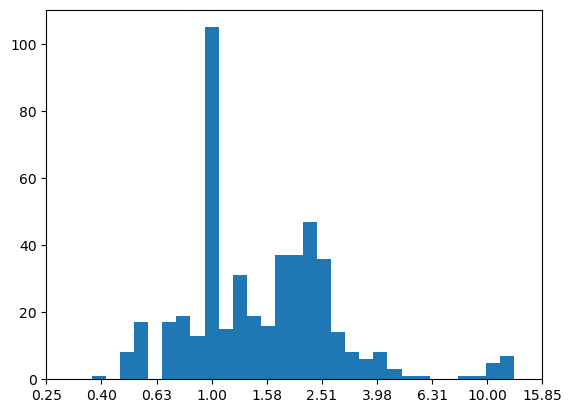

In [42]:
# let's have a look at the normed_rmssds we calculate
values = normed_rmssds.flatten()
print(f"np.min(values) = {np.min(values)}")
values[values == 0] = np.exp(-1)
print(f"np.min(values) = {np.min(values)}")
plt.hist(np.log10(values), bins=30)
xticks, labels =  plt.xticks()
# base10ticks = xticks/np.log(10)
base10labels = [f"{t:.2f}" for t in 10**xticks ]
plt.xticks(xticks,base10labels)
# /plt.xticks(xticks, np.exp(xticks))
# plt.xscale('log')

In [29]:
xticks

array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ])

In [30]:
labels

[Text(-1.5, 0, '−1.5'),
 Text(-1.0, 0, '−1.0'),
 Text(-0.5, 0, '−0.5'),
 Text(0.0, 0, '0.0'),
 Text(0.5, 0, '0.5'),
 Text(1.0, 0, '1.0'),
 Text(1.5, 0, '1.5'),
 Text(2.0, 0, '2.0'),
 Text(2.5, 0, '2.5'),
 Text(3.0, 0, '3.0')]